In [1]:
import pandas as pd
import numpy as np

from scipy import stats

from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import xgboost as Xgb
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load Data from https://www.kaggle.com/datasets/sapere0/bitcoinheist-ransomware-dataset/download?datasetVersionNumber=1
df=pd.read_csv('Downloads/BitcoinHeistData.csv')

In [3]:
print(df.head())

                              address  year  day  length    weight  count  \
0   111K8kZAEnJg245r2cM6y9zgJGHZtJPy6  2017   11      18  0.008333      1   
1  1123pJv8jzeFQaCV4w644pzQJzVWay2zcA  2016  132      44  0.000244      1   
2  112536im7hy6wtKbpH1qYDWtTyMRAcA2p7  2016  246       0  1.000000      1   
3  1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7  2016  322      72  0.003906      1   
4  1129TSjKtx65E35GiUo4AYVeyo48twbrGX  2016  238     144  0.072848    456   

   looped  neighbors       income            label  
0       0          2  100050000.0  princetonCerber  
1       0          1  100000000.0   princetonLocky  
2       0          2  200000000.0  princetonCerber  
3       0          2   71200000.0  princetonCerber  
4       0          1  200000000.0   princetonLocky  


In [4]:
# No null values
df.isnull()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
2916692,False,False,False,False,False,False,False,False,False,False
2916693,False,False,False,False,False,False,False,False,False,False
2916694,False,False,False,False,False,False,False,False,False,False
2916695,False,False,False,False,False,False,False,False,False,False


In [5]:
# No duplicated values
df.duplicated().value_counts()

False    2916697
dtype: int64

In [6]:
# Show Ransomware occurences by Year
df.query('label!="white"').groupby('year')['label'].value_counts()

year  label                      
2011  montrealCryptoLocker             65
2012  montrealCryptoLocker            714
2013  montrealCryptoLocker           7484
      montrealRazy                      8
      montrealNoobCrypt                 2
2014  paduaCryptoWall                9157
      montrealCryptoLocker           1050
      montrealNoobCrypt               109
      montrealGlobeImposter             2
      montrealCryptoTorLocker2015       1
2015  paduaCryptoWall                3233
      montrealNoobCrypt               300
      montrealDMALocker                73
      montrealCryptoTorLocker2015      53
      montrealGlobeImposter            38
      montrealCryptoLocker              2
      montrealRazy                      2
2016  princetonLocky                 6585
      princetonCerber                6043
      montrealCryptXXX               2419
      montrealDMALockerv3             193
      montrealDMALocker               178
      montrealNoobCrypt                72


In [7]:
# select only years with > 1k instances of ransomware to reduce data size
df=df.query('year > 2012 and year < 2018')
df['year'].value_counts()

2016    380631
2014    375319
2013    372494
2015    368701
2017    368486
Name: year, dtype: int64

In [8]:
# Label count
df['label'].value_counts()

white                          1825000
paduaCryptoWall                  12390
princetonCerber                   9223
montrealCryptoLocker              8536
princetonLocky                    6625
montrealCryptXXX                  2419
montrealNoobCrypt                  483
montrealDMALockerv3                354
montrealDMALocker                  251
montrealSamSam                      62
montrealCryptoTorLocker2015         55
montrealGlobeImposter               55
montrealGlobev3                     34
montrealGlobe                       32
montrealWannaCry                    28
montrealRazy                        12
montrealAPT                         11
paduaKeRanger                       10
montrealXTPLocker                    8
montrealXLockerv5.0                  7
montrealVenusLocker                  7
montrealCryptConsole                 7
montrealFlyper                       7
montrealEDA2                         6
montrealJigSaw                       4
paduaJigsaw              

In [9]:
# Drop columns not used for classification
df.drop(columns=["address","year","day"],axis=1,inplace=True)

In [10]:
#Create category "White" where 0 is ransomeware and 1 is NOT ransomware
df_dummy=pd.get_dummies(df['label'],dtype='float')
df['white']=df_dummy['white']
df.head()

,length,weight,count,looped,neighbors,income,label,white
0,18,0.008333,1,0,2,100050000.0,princetonCerber,0.0
1,44,0.000244,1,0,1,100000000.0,princetonLocky,0.0
2,0,1.000000,1,0,2,200000000.0,princetonCerber,0.0
3,72,0.003906,1,0,2,71200000.0,princetonCerber,0.0
4,144,0.072848,456,0,1,200000000.0,princetonLocky,0.0


In [11]:
# Note the imbalanced values for "White"
df['white'].value_counts(normalize=True)

1.0    0.978221
0.0    0.021779
Name: white, dtype: float64

In [12]:
# Random under sampling- create dataframes for ransomeware and not-ransomware
# combime 100% of rwr (ransomeware) with 3% of df_white to create a balanced dataset
df_white=df.query('white == 1')
print(df_white['label'].value_counts())

df_rwr=df.query('white == 0')
df_rwr['label'].value_counts()

white    1825000
Name: label, dtype: int64


paduaCryptoWall                12390
princetonCerber                 9223
montrealCryptoLocker            8536
princetonLocky                  6625
montrealCryptXXX                2419
montrealNoobCrypt                483
montrealDMALockerv3              354
montrealDMALocker                251
montrealSamSam                    62
montrealCryptoTorLocker2015       55
montrealGlobeImposter             55
montrealGlobev3                   34
montrealGlobe                     32
montrealWannaCry                  28
montrealRazy                      12
montrealAPT                       11
paduaKeRanger                     10
montrealXTPLocker                  8
montrealVenusLocker                7
montrealXLockerv5.0                7
montrealCryptConsole               7
montrealFlyper                     7
montrealEDA2                       6
montrealJigSaw                     4
paduaJigsaw                        2
montrealXLocker                    1
montrealSam                        1
m

In [13]:
# Randomly undersample by combining entire positive dataset with 3% of negative dataset
df_under_sample=df_white.sample(frac=.03,random_state=42).append(df_rwr)

/var/folders/nc/d0qq985n7zv3k6s5tl41yz4c0000gn/T/ipykernel_74937/2176034145.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_under_sample=df_white.sample(frac=.03,random_state=42).append(df_rwr)


In [14]:
df_under_sample.head()

,length,weight,count,looped,neighbors,income,label,white
2296118,42,3.051758e-05,1,0,2,3.859276e+08,white,1.0
873068,2,2.500000e-01,1,0,2,1.469950e+09,white,1.0
1566324,144,2.369196e-01,1028,1,2,2.424425e+08,white,1.0
2464558,12,3.478261e-07,1,0,1,4.280000e+07,white,1.0
2044142,6,5.000000e-01,1,0,2,4.440000e+07,white,1.0


<AxesSubplot:xlabel='white', ylabel='Count'>

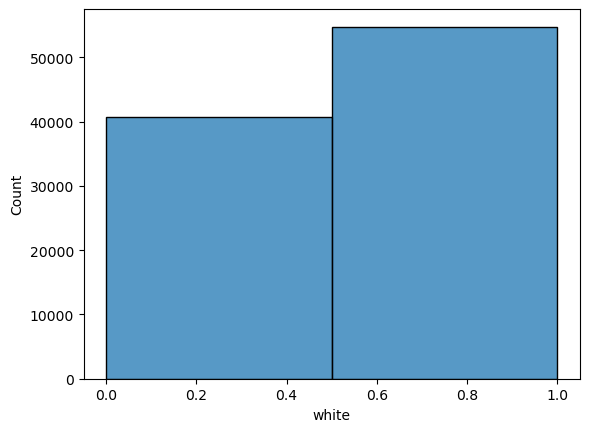

In [15]:
# 42:57 distribution reasonable to prepare for modeling
sns.histplot(df_under_sample['white'],bins=2)

In [16]:
# final check of column types-  will need to drop label for modeling because it is not numerical
df_under_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95381 entries, 2296118 to 41412
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   length     95381 non-null  int64  
 1   weight     95381 non-null  float64
 2   count      95381 non-null  int64  
 3   looped     95381 non-null  int64  
 4   neighbors  95381 non-null  int64  
 5   income     95381 non-null  float64
 6   label      95381 non-null  object 
 7   white      95381 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 6.5+ MB


In [17]:
# create training set for Random under sampling
X_under=df_under_sample.drop(['white','label'],axis=1)
y_under=df_under_sample['white']
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size=0.33, random_state=42)

In [18]:
# Check distribution- 1 is neutral, 0 is ransomware
y_under.value_counts(normalize=True)

1.0    0.574014
0.0    0.425986
Name: white, dtype: float64

In [19]:
# Use Near Miss to resample and create near miss (nm) training sets categorizing White Label
X_resample=df.drop(['white','label'],axis=1)
y_resample=df['white']
nm = NearMiss()
X_nm, y_nm = nm.fit_resample(X_resample, y_resample)
X_train_nm, X_test_nm, y_train_nm, y_test_nm = train_test_split(X_nm, y_nm, test_size=0.33, random_state=42)

In [20]:
#Distributions of white label for each dataset
print('undersampled: ', y_train_under.shape[0],'samples \n',y_train_under.value_counts(normalize=True))
print('near miss: ',y_train_nm.shape[0],'samples \n',y_train_nm.value_counts(normalize=True))


undersampled:  63905 samples 
 1.0    0.573085
0.0    0.426915
Name: white, dtype: float64
near miss:  54445 samples 
 1.0    0.501479
0.0    0.498521
Name: white, dtype: float64


In [21]:
#Scale Both Datasets
scaler=StandardScaler()

scaler.fit(X_train_under)
X_train_under_scaled=scaler.transform(X_train_under)
X_test_under_scaled=scaler.transform(X_test_under)


scaler.fit(X_train_nm)
X_train_nm_scaled=scaler.transform(X_train_nm)
X_test_nm_scaled=scaler.transform(X_test_nm)


# Searches for Optimal Parameters for Classifiers

In [22]:
# GridSearch to Optimize HGC for Near Miss
hgc_model=HistGradientBoostingClassifier()
param_grid = {
    "learning_rate": (0.01, 0.1, 1),
    "max_leaf_nodes": (50,100,200),
    "min_samples_leaf":(5,10,20),
    "max_iter":(200,300,400)
}
hgc_nm_grid_search = GridSearchCV(hgc_model, param_grid=param_grid, n_jobs=2, cv=2)
hgc_nm_grid_search.fit(X_train_nm_scaled, y_train_nm)
print(f"The best near miss HGC parameters are: {hgc_nm_grid_search.best_params_}")

The best near miss HGC parameters are: {'learning_rate': 0.1, 'max_iter': 200, 'max_leaf_nodes': 100, 'min_samples_leaf': 5}


In [23]:
# GridSearch to Optimize HGC for Under Sampling
hgc_model=HistGradientBoostingClassifier()
param_grid = {
    "learning_rate": (0.01, 0.1, 1),
    "max_leaf_nodes": (50,100,200),
    "min_samples_leaf":(5,10,20),
    "max_iter":(200,300,400)
}
hgc_under_grid_search = GridSearchCV(hgc_model, param_grid=param_grid, n_jobs=2, cv=2)
hgc_under_grid_search.fit(X_train_under_scaled, y_train_under)
print(f"The best under sampled HGC parameters are: {hgc_under_grid_search.best_params_}")

The best under sampled HGC parameters are: {'learning_rate': 0.1, 'max_iter': 200, 'max_leaf_nodes': 50, 'min_samples_leaf': 5}


In [24]:
# Build parameter grid for optimization of Random Forest

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 2, stop = 500, num = 6)]
# Number of features at each split
max_features = ['auto', 'sqrt']
# Max levels per tree
max_depth = [int(x) for x in np.linspace(5, 125, num = 6)]
max_depth.append(None)
# Minimum samples required to split node
min_samples_split = [2, 5,7,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5,10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create a grid
grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(grid)


{'n_estimators': [2, 101, 201, 300, 400, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 29, 53, 77, 101, 125, None], 'min_samples_split': [2, 5, 7, 10], 'min_samples_leaf': [1, 2, 5, 10], 'bootstrap': [True, False]}


In [25]:
# Randomized Search for best Randon Forest Near Miss hyperparameters
# Used Randomized over Grid Search to reduce processing time
rf = RandomForestClassifier()
random_rf_nm = RandomizedSearchCV(estimator = rf, param_distributions = grid, n_iter = 25, cv = 3, random_state=42, n_jobs = -1)
# Fit the random search model
random_rf_nm.fit(X_train_nm, y_train_nm)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 29, 53, 77, 101, 125,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 7, 10],
                                        'n_estimators': [2, 101, 201, 300, 400,
                                                         500]},
                   random_state=42)

In [26]:
# Random Search for best Random Forest hyperparameters for Under Sampled data set
rf = RandomForestClassifier()
random_rf_under = RandomizedSearchCV(estimator = rf, param_distributions = grid, n_iter = 25, cv = 3, random_state=42, n_jobs = -1)
# Fit the random search model
random_rf_under.fit(X_train_under, y_train_under)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 29, 53, 77, 101, 125,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 7, 10],
                                        'n_estimators': [2, 101, 201, 300, 400,
                                                         500]},
                   random_state=42)

In [27]:
# Find best parameters for XBG classification for near miss data set

xgb_nm = Xgb.XGBClassifier(n_jobs=7,tree_method="hist")
clf_nm = RandomizedSearchCV(
        xgb_nm,
        {"max_depth": [5, 25,50], "n_estimators": [100, 500,750,1000]},
        verbose=1,
        n_jobs=7)
clf_nm.fit(X_train_nm, y_train_nm)
print(clf_nm.best_score_)
print(clf_nm.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.8864542198548995
{'n_estimators': 750, 'max_depth': 25}


In [28]:
# Find best parameters for XBG classification for under sampled data set

xgb_under = Xgb.XGBClassifier(n_jobs=7,tree_method="hist")
clf_under = RandomizedSearchCV(
        xgb_under,
        {"max_depth": [5, 25,50], "n_estimators": [100, 500,750,1000]},
        verbose=1,
        n_jobs=7)
clf_under.fit(X_train_under, y_train_under)
print(clf_under.best_score_)
print(clf_under.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.7575933025584852
{'n_estimators': 100, 'max_depth': 5}


# Fit Models and Generate Predictions

In [29]:
#Instantiate All Models and global variables
knn=KNeighborsClassifier()
lr=LogisticRegression()
RFC_under=RandomForestClassifier(n_estimators=201, min_samples_split=10, min_samples_leaf=10,max_features='auto', max_depth=101,bootstrap=False)
RFC_nm=RandomForestClassifier(n_estimators=2, min_samples_split=5, min_samples_leaf=1,max_features='sqrt', max_depth=29,bootstrap=False)
HGC_under=HistGradientBoostingClassifier(learning_rate=0.1,max_iter=200,max_leaf_nodes=50,min_samples_leaf=20)
HGC_nm=HistGradientBoostingClassifier(learning_rate=1,max_iter=400,max_leaf_nodes=200,min_samples_leaf=20)
XGB_under=Xgb.XGBClassifier(n_jobs=7,tree_method="hist",n_estimators=100,max_depth=5)
XGB_nm=Xgb.XGBClassifier(n_jobs=7,tree_method="hist",n_estimators=750,max_depth=25)


# dataframe to store results
df_scores=pd.DataFrame(columns=['Model','DataSet','F1-Score'])

# dictionary to store results
model_scores={}


In [30]:
# Loop through each model against under sampled data set and store results in df_scores dataframe
models_under=(knn,lr,RFC_under,XGB_under,HGC_under)

for m in models_under:
    # determine name for storing and plotting results
    if m == knn:
        modelname='knn_'
        df_scores.loc[len(df_scores)]=('KNearesetNeighor','Under Sampled',0)
    elif m == lr:
        modelname='lr_'
        df_scores.loc[len(df_scores)]=('Logistic Regresion','Under Sampled',0)
    elif m == RFC_under:
        modelname='RFC_'
        df_scores.loc[len(df_scores)]=('Random Forest','Under Sampled',0)
    elif m == XGB_under:
        modelname='XBG_'
        df_scores.loc[len(df_scores)]=('XGBoost','Under Sampled',0)
    elif m == HGC_under:
        modelname='HGC_'
        df_scores.loc[len(df_scores)]=('HistGradientBoostingClassifier','Under Sampled',0)
        
    #name the model set     
    model_set=modelname+'under'
    print(model_set)
    
    #fit the model
    m.fit(X_train_under_scaled,y_train_under)
    
    #build predictions
    pred=m.predict(X_test_under_scaled)
    
    #Score the model with blended F1 accuracy and record result
    report=classification_report(y_test_under,pred,zero_division=1,output_dict=True)
    model_scores[model_set]=report['accuracy']
    df_scores.iloc[len(df_scores)-1,2]=(report['accuracy'])
    
print(model_scores)

knn_under


/Users/joshuagreenberg/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


lr_under
RFC_under
XBG_under
HGC_under
{'knn_under': 0.6798830855254797, 'lr_under': 0.5755496251111958, 'RFC_under': 0.7552738594484687, 'XBG_under': 0.7606747998475029, 'HGC_under': 0.7631528783835303}


In [31]:
# Loop through each model against near miss data set and store results in df_scores dataframe
# Run Random and Near Miss datasets separately to minimize wait time on the function

models_nm=(knn,lr,RFC_nm,XGB_nm,HGC_nm)
#models=(knn,lr)

for m in models_nm:
    # determine name for storing and plotting results
    if m == knn:
        modelname='knn_'
        df_scores.loc[len(df_scores)]=('KNearesetNeighor','Near Miss',0)
    elif m == lr:
        modelname='lr_'
        df_scores.loc[len(df_scores)]=('Logistic Regresion','Near Miss',0)
    elif m == RFC_nm:
        modelname='RFC_'
        df_scores.loc[len(df_scores)]=('Random Forest','Near Miss',0)
    elif m == XGB_nm:
        modelname='XGB_'
        df_scores.loc[len(df_scores)]=('XGBoost','Near Miss',0)
    elif m == HGC_nm:
        modelname='HGC_'
        df_scores.loc[len(df_scores)]=('HistGradientBoostingClassifier','Near Miss',0)
    
    #name the model set
    model_set=modelname+'nm'
    print(model_set)
    
    # fit the model
    m.fit(X_train_nm_scaled,y_train_nm)
    
    #build predictions
    pred=m.predict(X_test_nm_scaled)
    
    #Score the model with blended F1 accuracy and record result
    report=classification_report(y_test_nm,pred,zero_division=1,output_dict=True)
    model_scores[model_set]=report['accuracy']
    df_scores.iloc[len(df_scores)-1,2]=(report['accuracy'])

print(model_scores)

knn_nm


/Users/joshuagreenberg/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


lr_nm
RFC_nm
XGB_nm
HGC_nm
{'knn_under': 0.6798830855254797, 'lr_under': 0.5755496251111958, 'RFC_under': 0.7552738594484687, 'XBG_under': 0.7606747998475029, 'HGC_under': 0.7631528783835303, 'knn_nm': 0.8859678562106127, 'lr_nm': 0.7524704478502442, 'RFC_nm': 0.9074467688406608, 'XGB_nm': 0.8904799194540777, 'HGC_nm': 0.8588954767498229}


In [32]:
# clean up dataframe for graphing
df_scores['F1-Score']=df_scores['F1-Score'].round(decimals = 3)*100
df_scores=df_scores.sort_values(by='F1-Score')
print(df_scores.head(10))



                            Model        DataSet  F1-Score
1              Logistic Regresion  Under Sampled      57.6
0                KNearesetNeighor  Under Sampled      68.0
6              Logistic Regresion      Near Miss      75.2
2                   Random Forest  Under Sampled      75.5
3                         XGBoost  Under Sampled      76.1
4  HistGradientBoostingClassifier  Under Sampled      76.3
9  HistGradientBoostingClassifier      Near Miss      85.9
5                KNearesetNeighor      Near Miss      88.6
8                         XGBoost      Near Miss      89.0
7                   Random Forest      Near Miss      90.7


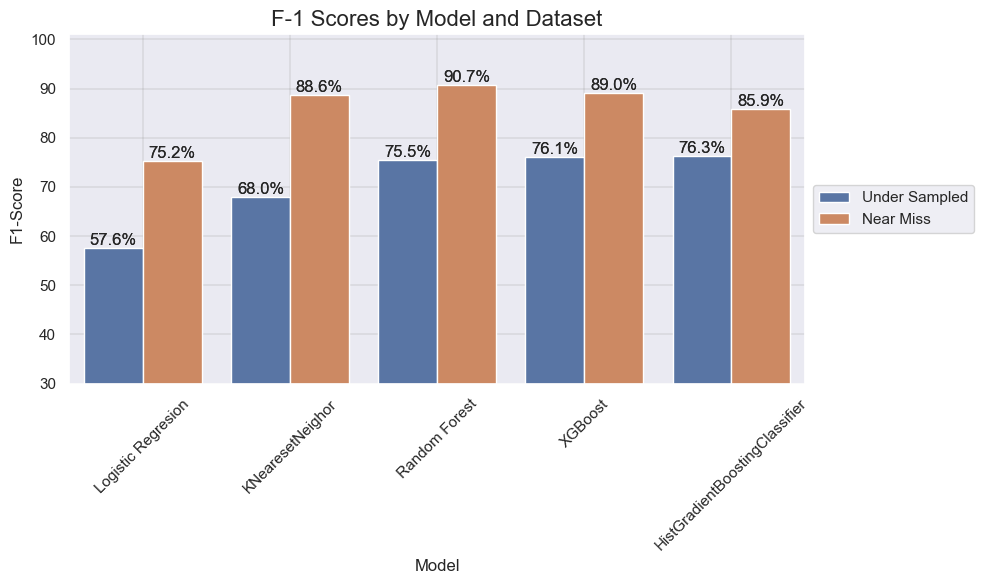

In [33]:
sns.set(rc={'figure.figsize':(10,6)})
ax1=sns.barplot(data=df_scores,x='Model',y='F1-Score',hue='DataSet')
#ax1.set(title='F-1 Scores by Model and Dataset')
plt.title('F-1 Scores by Model and Dataset',fontdict={'fontsize': 16})
for container in ax1.containers:
    ax1.bar_label(container=ax1.containers[0],fmt='%.1f%%')
    ax1.bar_label(container=ax1.containers[1],fmt='%.1f%%')
ax1.set_ylim(30, 101)
plt.xticks(rotation=45)
plt.grid(color='gray', linestyle='-', linewidth=0.2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.tight_layout();
ax1.figure.savefig('/var/local/data/bitcoin_heist_ransomware/images/F1-Scores-by-Model-Dataset.png')

# Repeat Modeling for Specifc Labels

In [34]:
#Generate scores for top five Ransomeware labels

# Create dummy labels within df
df_dummy=pd.get_dummies(df['label'],dtype='float')

# Labels we want to score
labels=('paduaCryptoWall','princetonCerber','montrealCryptoLocker','princetonLocky','montrealCryptXXX')

#objects used by loop
scores={}
scaler=StandardScaler()
RFC_nm_opt=RandomForestClassifier(n_estimators=2, min_samples_split=5, min_samples_leaf=1,max_features='sqrt', max_depth=29,bootstrap=False)

#Loop through each label and generate an F-1 Accuracy score
for label in labels:
    #prep dataframe to receive results
    df[label]=df_dummy[label]
    print(label)
    
    # prepare dataset 
    X=df.drop([label,'label','white'],axis=1)
    y=df[label]
    nm=NearMiss()
    
    # Build Near Miss dataset
    X_nm,y_nm=nm.fit_resample(X,y)
    
    #split dataset for cross validation
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33)
    
    # Scale the datasets
    scaler.fit(X_train)
    X_train_scaled=scaler.transform(X_train)
    X_test_scaled=scaler.transform(X_test)
    
    #Fit the training data set
    RFC_nm_opt.fit(X_train_scaled,y_train)

    #Generate predictions against test dataset
    pred=RFC_nm_opt.predict(X_test_scaled)
    
    #Score the predictions
    report=classification_report(y_test,pred,zero_division=1,output_dict=True)
    
    #record results in a dictionary and print results
    scores[label]=report['accuracy']*100
    print(report['accuracy'])
print(scores)

paduaCryptoWall
0.991743806230397
princetonCerber
0.9948851555812552
montrealCryptoLocker
0.9945667975291517
princetonLocky
0.9960871196555235
montrealCryptXXX
0.9988678797841013
{'paduaCryptoWall': 99.17438062303971, 'princetonCerber': 99.48851555812553, 'montrealCryptoLocker': 99.45667975291516, 'princetonLocky': 99.60871196555236, 'montrealCryptXXX': 99.88678797841013}


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


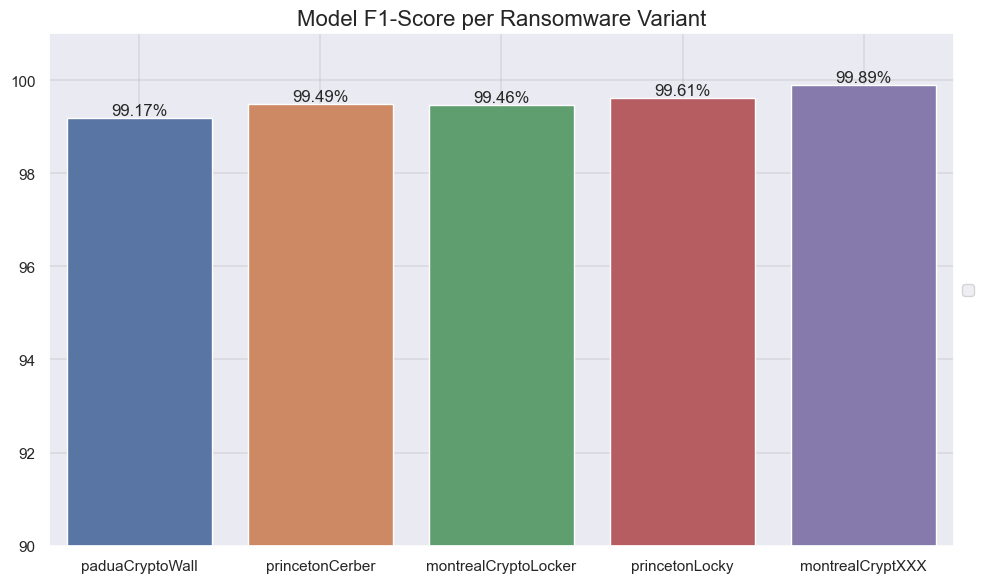

In [35]:
# Plot the results of the label specific models

# build a dictionary of scores and labels for plotting results
keys = list(scores.keys())
vals=[]

for i,j in scores.items():
    vals.append(round(j,4))
    #print(j)
ax2=sns.barplot(x=keys, y=vals)

# print scores and add '%' to the bars on the plot
for container in ax2.containers:
    ax2.bar_label(container=ax2.containers[0],fmt='%.2f%%')
ax2.set_ylim(90, 101)
#plt.xticks(rotation=45)
plt.grid(color='gray', linestyle='-', linewidth=0.2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Model F1-Score per Ransomware Variant',fontdict={'fontsize': 16})
plt.tight_layout();
ax2.figure.savefig('/var/local/data/bitcoin_heist_ransomware/images/F1-Scores-by-Label.png')



# Feature Importance Exploration

In [36]:
# Looking at mean and std it is not easy to find a pattern visually
df.groupby('label').mean()

,length,weight,count,looped,neighbors,income,white,paduaCryptoWall,princetonCerber,montrealCryptoLocker,princetonLocky,montrealCryptXXX
label,,,,,,,,,,,,
montrealAPT,67.636364,0.707728,2047.000000,734.090909,2.545455,3.719873e+08,0.0,0.0,0.0,0.0,0.0,0.0
montrealComradeCircle,144.000000,0.051214,1241.000000,0.000000,2.000000,2.033200e+08,0.0,0.0,0.0,0.0,0.0,0.0
montrealCryptConsole,43.428571,0.593306,831.714286,0.000000,2.000000,4.546334e+07,0.0,0.0,0.0,0.0,0.0,0.0
montrealCryptXXX,47.447706,0.367505,791.848284,61.022323,2.011988,1.355343e+08,0.0,0.0,0.0,0.0,0.0,1.0
montrealCryptoLocker,31.999297,0.940305,335.540300,110.052366,2.937559,1.941361e+09,0.0,0.0,0.0,1.0,0.0,0.0
montrealCryptoTorLocker2015,20.581818,1.193597,220.363636,166.636364,10.218182,6.807846e+08,0.0,0.0,0.0,0.0,0.0,0.0
montrealDMALocker,38.828685,0.968445,897.163347,430.482072,1.844622,8.894276e+08,0.0,0.0,0.0,0.0,0.0,0.0
montrealDMALockerv3,37.711864,0.535983,962.875706,94.550847,1.158192,6.105896e+08,0.0,0.0,0.0,0.0,0.0,0.0
montrealEDA2,74.333333,0.171074,4355.166667,951.500000,1.333333,3.785209e+07,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# Instantiate a Random Forest to analyze Feature Importance
Xf=df.drop(['label','princetonCerber','white','paduaCryptoWall','montrealCryptoLocker','princetonLocky','montrealCryptXXX'],axis=1)
yf=df['white']
Xf_train,Xf_test,yf_train,yf_test=train_test_split(Xf,yf,test_size=0.33)
scaler.fit(Xf_train)
Xf_train_scaled=scaler.transform(Xf_train)
Xf_test_scaled=scaler.transform(Xf_test)
RFC_nm_opt.fit(Xf_train_scaled,yf_train)

RandomForestClassifier(bootstrap=False, max_depth=29, max_features='sqrt',
                       min_samples_split=5, n_estimators=2)

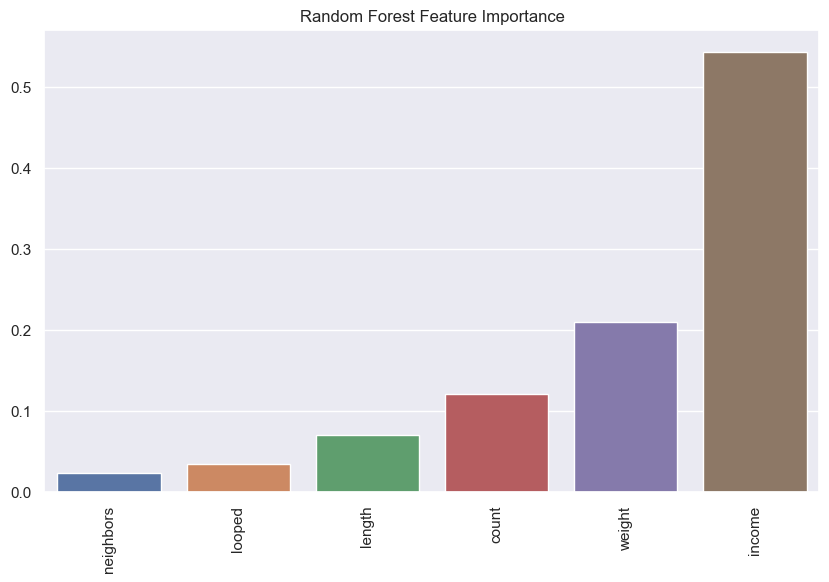

In [38]:
# Plot Feature importance from Random Forest above
df_rf_features=pd.DataFrame(columns=scaler.get_feature_names_out())
df_rf_features.loc[len(df_rf_features)] = RFC_nm_opt.feature_importances_
df_rf_features=df_rf_features.sort_values(by=0, ascending=True, axis=1)
df_rf_features.head()
sns.barplot(data=df_rf_features).set(title='Random Forest Feature Importance')
plt.xticks(rotation=90);

In [39]:
#Instantiate XGB to invesigate feature importance
Xx=df.drop(['label','princetonCerber','white','paduaCryptoWall','montrealCryptoLocker','princetonLocky','montrealCryptXXX'],axis=1)
yx=df['princetonCerber']
Xx_train,Xx_test,yx_train,yx_test=train_test_split(Xx,yx,test_size=0.33)
scaler.fit(Xx_train)
Xx_train_scaled=scaler.transform(Xx_train)
Xx_test_scaled=scaler.transform(Xx_test)
XGB_under.fit(Xx_train_scaled,yx_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=7, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [40]:
# Build a cohort income and weight lower than princeton cerber- the two most important features acc to RF
pc_income=df.query('label == "princetonCerber"')['income'].mean()*.5
pc_weight=df.query('label == "princetonCerber"')['weight'].mean()*.5
pc_cohort=df.query('income < @pc_income and weight < @pc_weight')

# Compare percentage of princetonCerber in general cohort to low weight/income
# results show no material difference

print(pc_cohort['white'].mean())
print(df['white'].mean())
print(pc_cohort['princetonCerber'].mean())
print(df['princetonCerber'].mean())

0.9843045594688722
0.9782213095730078
0.004042058719726179
0.004943635692159918


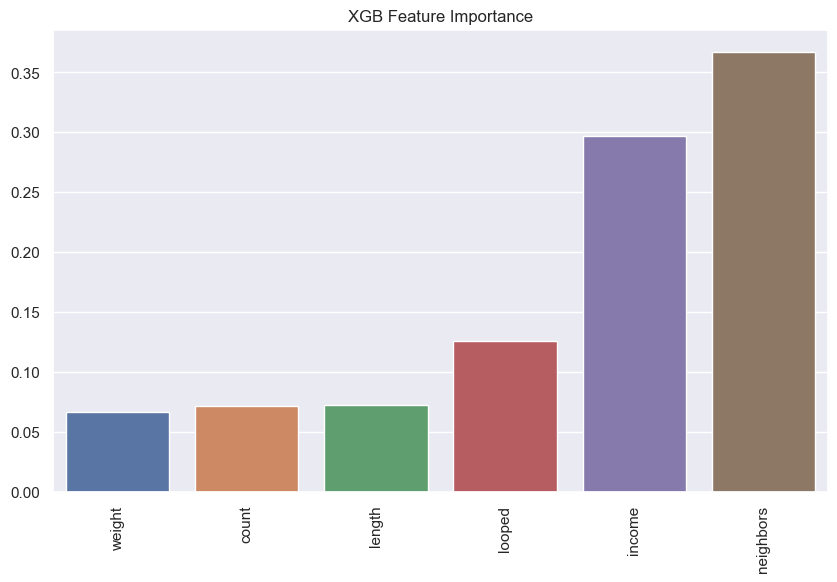

In [41]:
# Plot Feature importance from XGB above
df_rf_features=pd.DataFrame(columns=scaler.get_feature_names_out())
df_rf_features.loc[len(df_rf_features)] = XGB_under.feature_importances_
df_rf_features=df_rf_features.sort_values(by=0, ascending=True, axis=1)
df_rf_features.head()
sns.barplot(data=df_rf_features).set(title='XGB Feature Importance')
plt.xticks(rotation=90);

In [42]:
# Build a cohort with low income and high neighbors weight based on princetonCerber
pc_neighbors=df.query('label == "princetonCerber"')['neighbors'].mean()
pc_weight=df.query('label == "princetonCerber"')['weight'].mean()
pc_cohort=df.query('neighbors > @pc_neighbors and weight < @pc_weight')

# Compare percentage of princetonCerber in general cohort to low weight/high neighbors
# results show no material difference
print(pc_cohort['white'].mean())
print(df['white'].mean())
print(pc_cohort['princetonCerber'].mean())
print(df['princetonCerber'].mean())

0.9767596061399728
0.9782213095730078
0.001392434439545138
0.004943635692159918


In [43]:
# Build a cohort with low loop and high count based on princetonCerber
pc_count=df.query('label == "princetonCerber"')['count'].mean()
pc_looped=df.query('label == "princetonCerber"')['looped'].mean()
pc_cohort=df.query('count > @pc_count and looped < @pc_looped')

# Compare percentage of princetonCerber in general cohort to high count/low looped
# results show minor increase in % of princetonCerber in cohort but actual decrease in ransomware over all
print(pc_cohort['white'].mean())
print(df['white'].mean())
print(pc_cohort['princetonCerber'].mean())
print(df['princetonCerber'].mean())

0.9766107030054028
0.9782213095730078
0.005772036811971419
0.004943635692159918


In [44]:
#Build dataframe to show feature means by ransomware variant

feature_df=pd.DataFrame(columns=['Address-Type','Neighbors','Income','Count','Weight','Looped','Length'])
feature_df.loc[len(feature_df)]=('Normal',df.query('label == "white"')['neighbors'].mean(),
                                df.query('label == "white"')['income'].mean()/10_000_000,
                                 df.query('label == "white"')['count'].mean(),
                                 df.query('label == "white"')['weight'].mean()*100,
                                 df.query('label == "white"')['looped'].mean(),
                                 df.query('label == "white"')['length'].mean()
                                )
feature_df.loc[len(feature_df)]=('Ransomware',df.query('label != "white"')['neighbors'].mean(),
                                df.query('label != "white"')['income'].mean()/10_000_000,
                                 df.query('label != "white"')['count'].mean(),
                                 df.query('label != "white"')['weight'].mean()*100,
                                 df.query('label != "white"')['looped'].mean(),
                                 df.query('label != "white"')['length'].mean()
                                )


In [45]:
feature_df.head()

,Address-Type,Neighbors,Income,Count,Weight,Looped,Length
0,Normal,2.211935,232.979372,849.012568,55.349935,315.993761,52.618640
1,Ransomware,2.071768,78.426850,611.003495,63.328474,96.900569,42.125028


In [46]:
#Build a Dataframe of mean values for various malware addresses, and compare to the field
# Scale Income and Weight so that they fit on the graph sensibly with other values
feature_df=pd.DataFrame(columns=['Address-Type','Neighbors','Income','Count','Weight','Looped','Length'])
feature_df.loc[len(feature_df)]=('Non-Ransomware',df.query('label == "white"')['neighbors'].mean(),
                                df.query('label == "white"')['income'].mean()/10_000_000,
                                 df.query('label == "white"')['count'].mean()/4,
                                 df.query('label == "white"')['weight'].mean()*100,
                                 df.query('label == "white"')['looped'].mean(),
                                 df.query('label == "white"')['length'].mean()
                                )

feature_df.loc[len(feature_df)]=('All Ransomware',df.query('label != "white"')['neighbors'].mean(),
                                df.query('label != "white"')['income'].mean()/10_000_000,
                                 df.query('label != "white"')['count'].mean()/4,
                                 df.query('label != "white"')['weight'].mean()*100,
                                 df.query('label != "white"')['looped'].mean(),
                                 df.query('label != "white"')['length'].mean()
                                )

feature_df.loc[len(feature_df)]=('princetonCerber',df.query('label == "princetonCerber"')['neighbors'].mean(),
                                df.query('label == "princetonCerber"')['income'].mean()/10_000_000,
                                 df.query('label == "princetonCerber"')['count'].mean()/4,
                                 df.query('label == "princetonCerber"')['weight'].mean()*100,
                                 df.query('label == "princetonCerber"')['looped'].mean(),
                                 df.query('label == "princetonCerber"')['length'].mean()
                                )
feature_df.loc[len(feature_df)]=('montrealCryptXXX',df.query('label == "montrealCryptXXX"')['neighbors'].mean(),
                                df.query('label == "montrealCryptXXX"')['income'].mean()/10_000_000,
                                 df.query('label == "montrealCryptXXX"')['count'].mean()/4,
                                 df.query('label == "montrealCryptXXX"')['weight'].mean()*100,
                                 df.query('label == "montrealCryptXXX"')['looped'].mean(),
                                 df.query('label == "montrealCryptXXX"')['length'].mean()
                                )
feature_df.loc[len(feature_df)]=('paduaCryptoWall',df.query('label == "paduaCryptoWall"')['neighbors'].mean(),
                                df.query('label == "paduaCryptoWall"')['income'].mean()/10_000_000,
                                 df.query('label == "paduaCryptoWall"')['count'].mean()/4,
                                 df.query('label == "paduaCryptoWall"')['weight'].mean()*100,
                                 df.query('label == "paduaCryptoWall"')['looped'].mean(),
                                 df.query('label == "paduaCryptoWall"')['length'].mean()
                                )
feature_df.loc[len(feature_df)]=('montrealCryptoLocker',df.query('label == "montrealCryptoLocker"')['neighbors'].mean(),
                                df.query('label == "montrealCryptoLocker"')['income'].mean()/10_000_000,
                                 df.query('label == "montrealCryptoLocker"')['count'].mean()/4,
                                 df.query('label == "montrealCryptoLocker"')['weight'].mean()*100,
                                 df.query('label == "montrealCryptoLocker"')['looped'].mean(),
                                 df.query('label == "montrealCryptoLocker"')['length'].mean()
                                )
feature_df.loc[len(feature_df)]=('princetonLocky',df.query('label == "princetonLocky"')['neighbors'].mean(),
                                df.query('label == "princetonLocky"')['income'].mean()/10_000_000,
                                 df.query('label == "princetonLocky"')['count'].mean()/4,
                                 df.query('label == "princetonLocky"')['weight'].mean()*100,
                                 df.query('label == "princetonLocky"')['looped'].mean(),
                                 df.query('label == "princetonLocky"')['length'].mean()
                                )



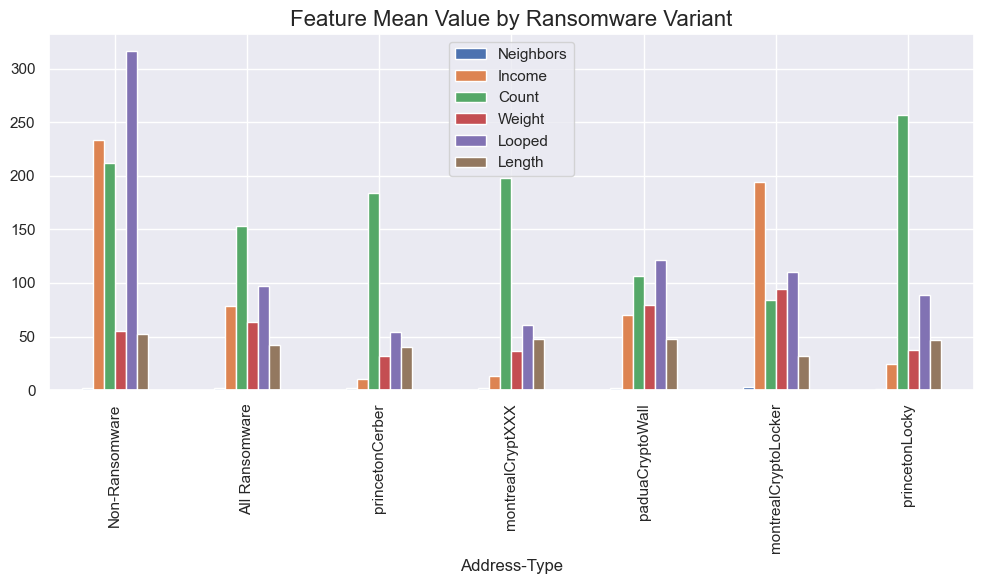

In [47]:
#plot the means of various malware
ax4=feature_df.plot.bar(x='Address-Type',y=['Neighbors','Income','Count','Weight','Looped','Length'])

#ax4.set(title='Feature Means by Address Type')
plt.title('Feature Mean Value by Ransomware Variant',fontdict={'fontsize': 16})
plt.tight_layout();
ax4.figure.savefig('/var/local/data/bitcoin_heist_ransomware/images/Means-by-Label.png')


In [48]:
# Build dataframe to display a pair plot.  
#Strongest correlation is count:looped
# We briefly attempt to build a cohort based on this relationship above but do not find a usable pattern 
df_skew=df[['count','weight','length','income','neighbors','label','looped']]
df_skew=df_skew.query('label == "princetonCerber"')
df_skew=df_skew.drop('label',axis=1)
df_skew=df_skew.reset_index()
df_skew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9223 entries, 0 to 9222
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      9223 non-null   int64  
 1   count      9223 non-null   int64  
 2   weight     9223 non-null   float64
 3   length     9223 non-null   int64  
 4   income     9223 non-null   float64
 5   neighbors  9223 non-null   int64  
 6   looped     9223 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 504.5 KB


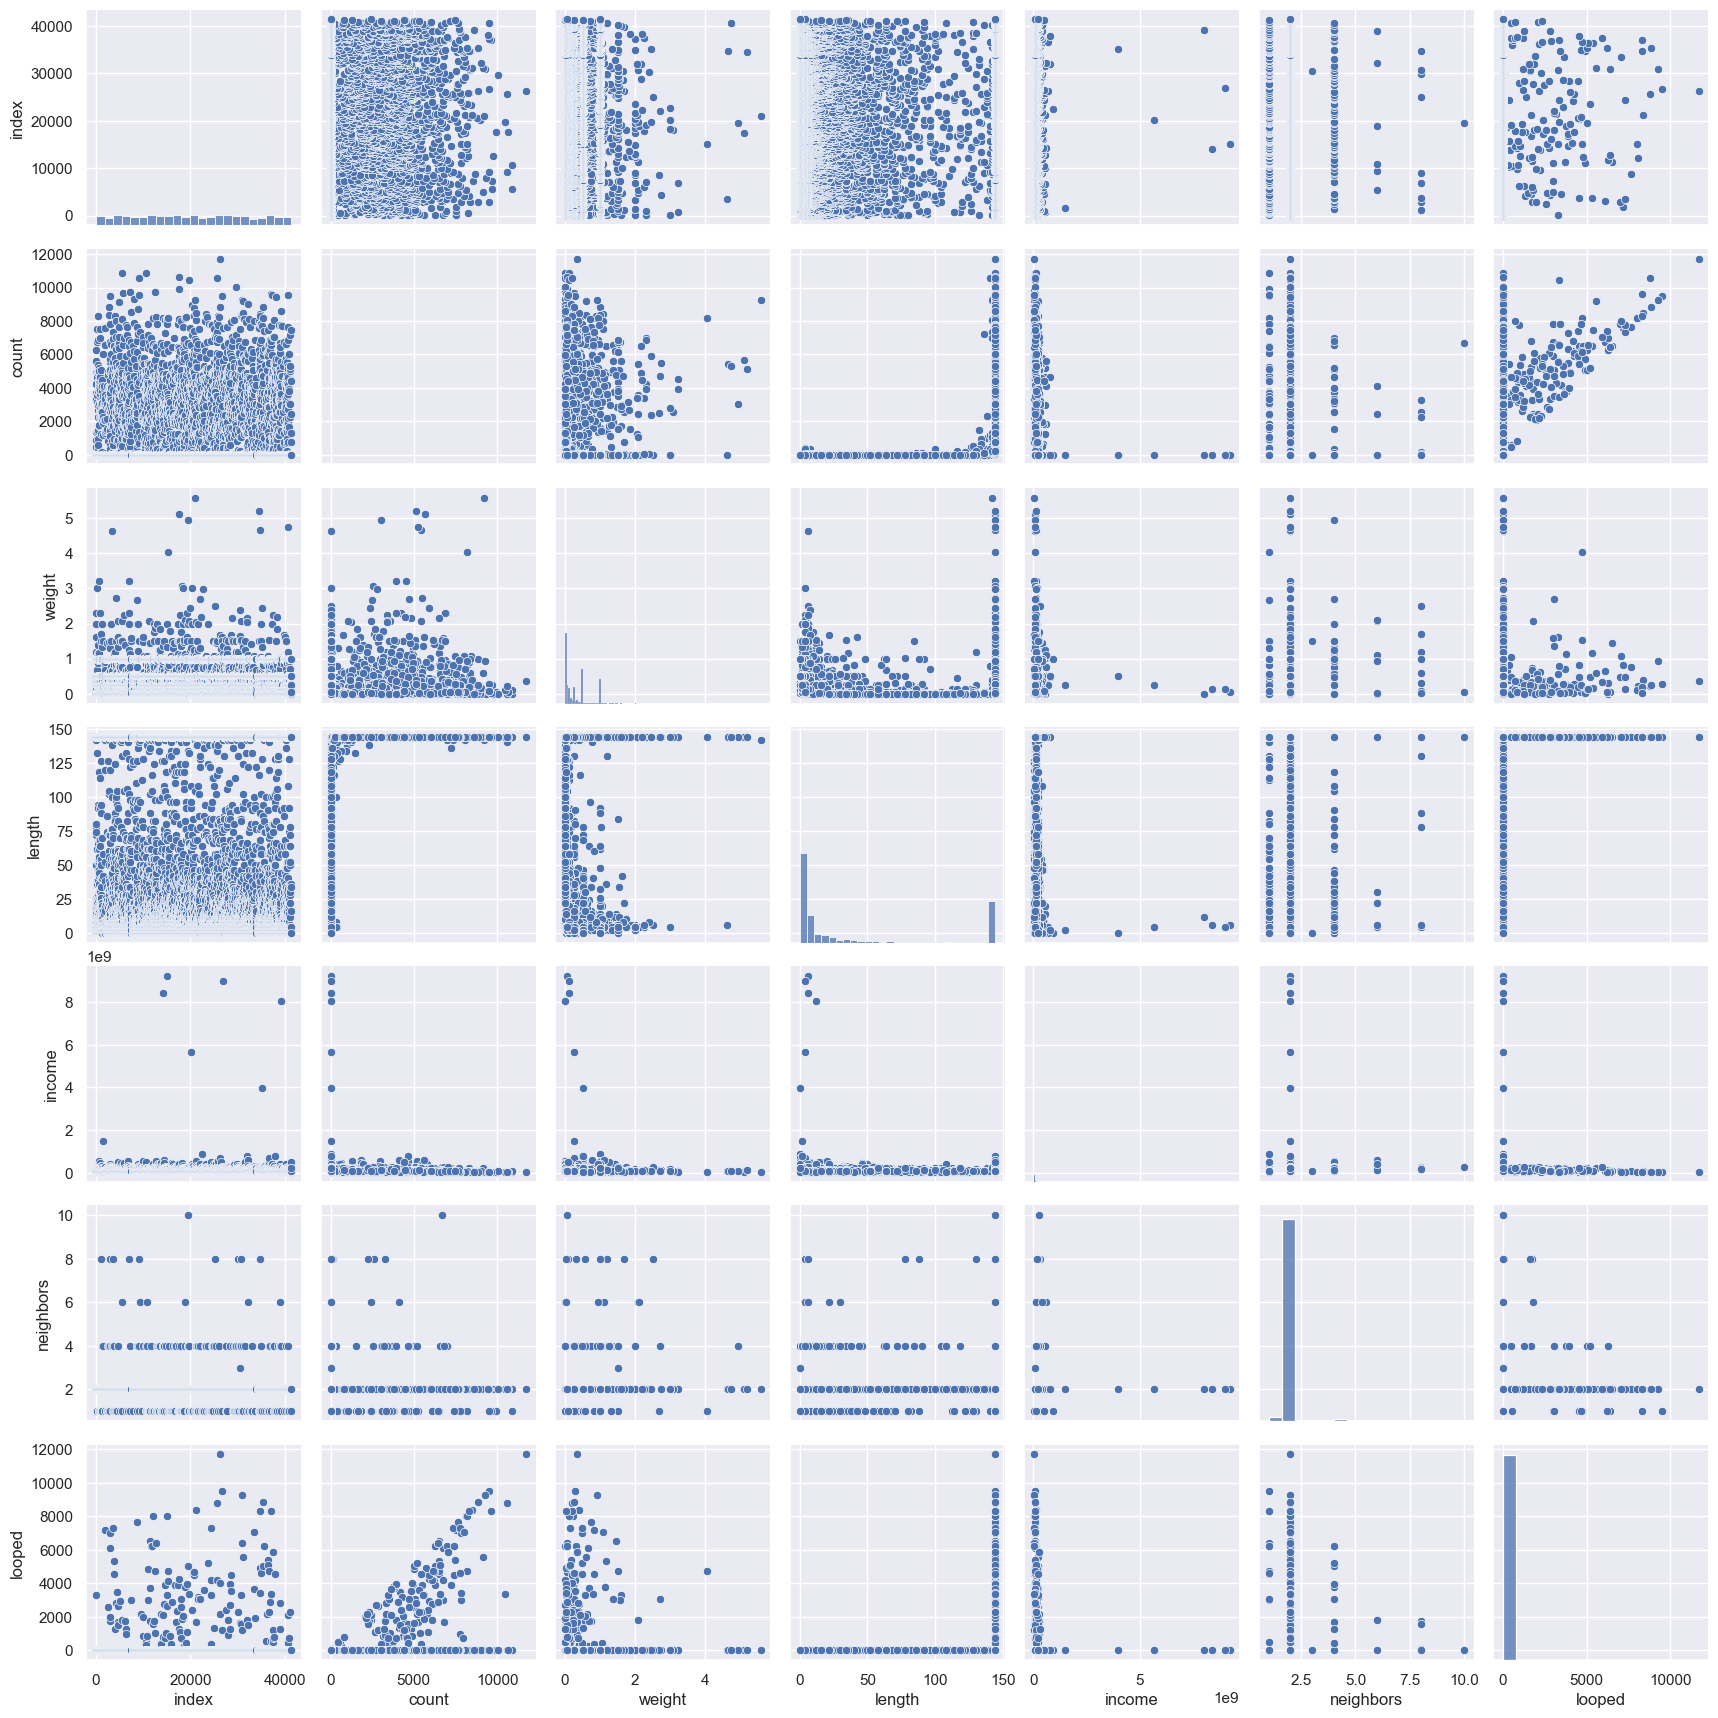

In [49]:
# no obvious correlations, even within the cohort for a specific malware!
sns.pairplot(df_skew)